<a href="https://colab.research.google.com/github/smarttransit-ai/transit-occupancy-dashboard/blob/master/app/dataprep/chattanooga/Chattanooga_Occupancy_DataAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import datetime
from datetime import timedelta
import calendar
import tqdm
import operator
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
from google.colab import drive 
ROOT = "/content/drive"           
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Dataset**

The following CSV file is generated from Joined APC and GTFS dataset "**chattanooga_bus_occupancy_jan20_through_jun20.csv**" 

1. The Null columns have been removed
2. Only the columns are kept which might be significant for the prediction
3. Added a "Date" column with Date-time features - done using 'SURVEY_DATE' and 'arrival_time'
4. "Day of week" column to represent the day of the week.

In [ ]:
copied_path = 'drive/My Drive/chattanooga_bus_occupancy_jan20_through_jun20_withDate_DOW.csv' 
data = pd.read_csv(copied_path,low_memory=False)
print(data.columns)
print(len(data.columns))


Index(['SCHEDULE_ID', 'SCHEDULE_NAME', 'TIME_PERIOD', 'SERVICE_PERIOD',
       'service_id', 'direction_id', 'TRAVEL_DIRECTION', 'SURVEY_DATE',
       'TRIP_START_TIME', 'TRIP_NUMBER', 'TRIP_KEY', 'trip_id', 'BLOCK_NUMBER',
       'BLOCK_NAME', 'RUN_NUMBER', 'block_id', 'VEHICLE_NUMBER',
       'VEHICLE_SEATS', 'PASSENGERS_ON', 'PASSENGERS_OFF', 'PASSENGERS_IN',
       'WHEELCHAIRS', 'BICYCLES', 'route_id', 'STOP_ID', 'FIRST_LAST_STOP',
       'stop_sequence', 'stop_name', 'stop_lat', 'stop_lon', 'arrival_time',
       'departure_time', 'new_arrival_time', 'Date_Time', 'Day_of_Week'],
      dtype='object')
35


# **Description of different columns**

**Trip Schedule Information**
1. 'SCHEDULE_ID', 'SCHEDULE_NAME' represents the GTFS schedules. 7 different ids correspond to 7 different schedule.
2. 'TIME_PERIOD': AM Early, AM Peak, Midday, PM Peak, PM Late, Other  
3. 'SERVICE_PERIOD' = {'Sunday', 'Weekday', 'Saturday'} and 'service_id' = {1.0, 2.0, 3.0}, service_id identifies a set of dates when service is available for one or more routes.

**Direction of the trip**
4. 'direction_id' = {1 (Inbound), 0 (Outbound)}
5. 'TRAVEL_DIRECTION' = {'E', 'S', 'W', 'N', 'X'}. Inbound and Outbound both have these 5 travel direction. Not sure what 'X' represents.

**Trip Information**
6. 'SURVEY_DATE' = Date of the actual trip/date APC data was recorded
7. 'TRIP_START_TIME' = represents time in the format 1/0/00, not useful.
8. 'TRIP_NUMBER' = Unique number of different trips
9. 'trip_id' = 'TRIP_KEY' + 3 digits (020)
10. trip_id' = On **a particular day**, **one trip id** represents **an unique trip**, one vehicle runs on the trip. The vehicle may be a different one on the same trip_id on a different day.


**Block Information**
11. 'BLOCK_NUMBER'=
12. 'BLOCK_NAME' = 
13. 'RUN_NUMBER' =
14. 'block_id' = 

**Vehicle Information**
15. 'VEHICLE_NUMBER' = Unique for one vehicle. Should correspond with Viriciti/clever data  
16. VEHICLE_SEATS = Number of seats in the vehicle


 **Boarding/Alighting Information**
17. 'PASSENGERS_ON' = Board count at one stop
18. 'PASSENGERS_OFF'= Alight count at one stop
19. 'PASSENGERS_IN' = Occupancy of the vehicle after vehicle leaves a stop
20. 'WHEELCHAIRS' = Number of wheelchairs getting on bus at stop  
21. 'BICYCLES' = Number of bikes coming on bus at stop - always 0 (missing?)

**Route Information**
22. 'route_id' = Unique identifier for routes


**STOP Information**
23. STOP_ID = unique identifier for Stops from APC. Matches with GTFS stop_id
24. 'stop_sequence' = Sequence of the stops along a unique trip on a particular day.
25. 'FIRST_LAST_STOP' The trip starts from a FIRST_LAST_STOP = 1 (First Stop), moves through a number of FIRST_LAST_STOP = 2 (Intermediate Stops along the trip) and end at FIRST_LAST_STOP = 3 (Last stop for the trip)
26. 'stop_name' = name of the stops from GTFS
27. 'stop_lat', 'stop_lon' = Coordinates of the stop
28. 'arrival_time' = 'departure_time' = ariival/departure time at the stop along the trip from GTFS

**Modified Date Time Information**
29. 'new_arrival_time' = In the gtfs data, hour ranges from 1-24. To use python datetime which only converts hours in the range 0-23, I used this coulmn.
30. 'Date_Time' = Date of the trip + arrival time of the trip as datetime object
31. 'Day_of_Week' = represents the day of the week
---




In [ ]:
print('\nRoutes with number of trips in the dataset:')
print(data.groupby(data['route_id'].fillna('None')).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'}))

MissingTime_forTrips = data.arrival_time.isna().sum()
print(f'Number of trips without a route_id = {data.route_id.isna().sum()}')
print(f'Number of trips without a arrival_time = {data.arrival_time.isna().sum()}')
print(f'Number of trips without a direction_id = {data.direction_id.isna().sum()}')
print(f'\n\nSame {MissingTime_forTrips} trips are missing GTFS information (route, direction, arrival_time, etc.) \nTotal {round(MissingTime_forTrips/len(data)*100,2)}% of the trips')

print('\nTrips running on schedule:')
print(data.groupby(['SCHEDULE_ID', 'SCHEDULE_NAME']).size().reset_index().rename(columns={0: 'count'}))


Routes with number of trips in the dataset:
   route_id   count
0         4  874943
1         9  324288
2      None  316339
3         1  308970
4        33  305792
5        16  295936
6       10G  260752
7       10A  170847
8        14  114533
9        21  108012
10       13   94913
11        8   59459
12       19   52273
13      10C   41908
14       34   33557
15       15   29697
16        2   25915
17        7   22446
18       28   22322
19        3    3628
Number of trips without a route_id = 316339
Number of trips without a arrival_time = 316339
Number of trips without a direction_id = 316339


Same 316339 trips are missing GTFS information (route, direction, arrival_time, etc.) 
Total 9.13% of the trips

Trips running on schedule:
   SCHEDULE_ID     SCHEDULE_NAME    count
0          105    Aug18 (Sunday)      332
1          109   May19 (Weekday)     2186
2          110  Aug19 (Saturday)   273248
3          111    Aug19 (Sunday)   101253
4          112   Aug19 (Weekday)  2149984
5

# **Dropping Trips**

After confirming that the same trips are missing these information (route,time, direction, etc.), I have removed the trips from the dataset.

Removing these trips also solve the scheduling problem (schedule from 2018).


In [ ]:
df = data.dropna(subset=['route_id'])

print(df.groupby(['SCHEDULE_ID', 'SCHEDULE_NAME']).size().reset_index().rename(columns={0: 'count'}))

   SCHEDULE_ID     SCHEDULE_NAME    count
0          110  Aug19 (Saturday)   250339
1          111    Aug19 (Sunday)    93544
2          112   Aug19 (Weekday)  1933206
3          113    Apr20 (Sunday)    58084
4          114   Apr20 (Weekday)   815018


# **Busy Routes**

Trip information sorted by routes

In [ ]:
print(df.groupby(df['route_id'].fillna('None')).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'}))

   route_id   count
0         4  874943
1         9  324288
2         1  308970
3        33  305792
4        16  295936
5       10G  260752
6       10A  170847
7        14  114533
8        21  108012
9        13   94913
10        8   59459
11       19   52273
12      10C   41908
13       34   33557
14       15   29697
15        2   25915
16        7   22446
17       28   22322
18        3    3628


# ***Trip scheduling based on weekday/weekend***

A few trips on these routes are running on different schedule

*   Route 1 - Weekday Schedule on a Saturday
*   Route 10G - Weekday Schedule on a Saturday
*   Route 10A - Sunday Schedule on a Saturday

In [ ]:
print(df.groupby(['Day_of_Week', 'SERVICE_PERIOD']).size().reset_index().rename(columns={0: 'count'}))

   Day_of_Week SERVICE_PERIOD   count
0            0        Weekday  518476
1            1        Weekday  511137
2            2        Weekday  534532
3            3        Weekday  564720
4            4        Weekday  618843
5            5       Saturday  249928
6            5        Weekday     516
7            6       Saturday     411
8            6         Sunday  151628


# Trips on the busiest route (**4**)

In [ ]:
Route_4_DF = (df[df.route_id == '4'])
print(len(Route_4_DF))

874943


# Trips of Route 4

* 332 different trips (trip_ids) running on route 4
* 166 trips in Inbound(1) direction, 166 in Outbound(0) direction
* Different trips have different number of stops

In [ ]:
print(Route_4_DF.groupby(['trip_id','SERVICE_PERIOD','SCHEDULE_NAME']).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'}))

print('\n\n')
Trips_route4 = Route_4_DF.trip_id.unique()
Number_of_Stops = []
for i in Trips_route4:
  Trip_Specific = Route_4_DF[Route_4_DF.trip_id == i]
  Number_of_Stops.append(len(Trip_Specific.groupby(['STOP_ID']).size().reset_index().rename(columns={0: 'count'})))
  # print(f"Trip {i} has {len(Trip_Specific.groupby(['STOP_ID']).size().reset_index().rename(columns={0: 'count'}))} Stops")

print(len(Trips_route4))
print(len(Number_of_Stops))

         trip_id SERVICE_PERIOD     SCHEDULE_NAME  count
0    139685020.0        Weekday   Aug19 (Weekday)   6048
1    139686020.0        Weekday   Aug19 (Weekday)   5940
2    139639020.0        Weekday   Aug19 (Weekday)   5616
3    139750020.0        Weekday   Aug19 (Weekday)   5544
4    139687020.0        Weekday   Aug19 (Weekday)   5445
..           ...            ...               ...    ...
327  139823070.0       Saturday  Aug19 (Saturday)    430
328  139833070.0       Saturday  Aug19 (Saturday)    396
329  139734020.0        Weekday   Aug19 (Weekday)    288
330  139695020.0        Weekday   Aug19 (Weekday)    245
331  139694020.0        Weekday   Aug19 (Weekday)    224

[332 rows x 4 columns]



332
332


# Grouping Route 4 Inbound and Outbound Trips by Total Boarding Count at each Stop

In [ ]:
Inbound = (Route_4_DF[Route_4_DF.direction_id == 1])
Inbound_Stops = Inbound.groupby(['STOP_ID'])['PASSENGERS_ON'].sum().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
print(f'Inbound_Stops\n\n{Inbound_Stops}')

Outbound = (Route_4_DF[Route_4_DF.direction_id == 0])
Outbound_Stops = Outbound.groupby(['STOP_ID'])['PASSENGERS_ON'].sum().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
print(f'\n\nOutbound_Stops\n\n{Outbound_Stops}')

Inbound_Stops

     STOP_ID  PASSENGERS_ON
0       1919           9875
1       1883           7742
2        923           5345
3       1820           3827
4        972           2511
..       ...            ...
145     1018              0
146     1922              0
147     1975              0
148      771              0
149     1019              0

[150 rows x 2 columns]


Outbound_Stops

     STOP_ID  PASSENGERS_ON
0         12           7559
1       1555           6935
2       1353           6893
3        805           3964
4       1351           3757
..       ...            ...
137     1878              0
138     1472              0
139     1473              0
140     1482              0
141     1466              0

[142 rows x 2 columns]


# Average Occupancy at Each Stop in Both Direction

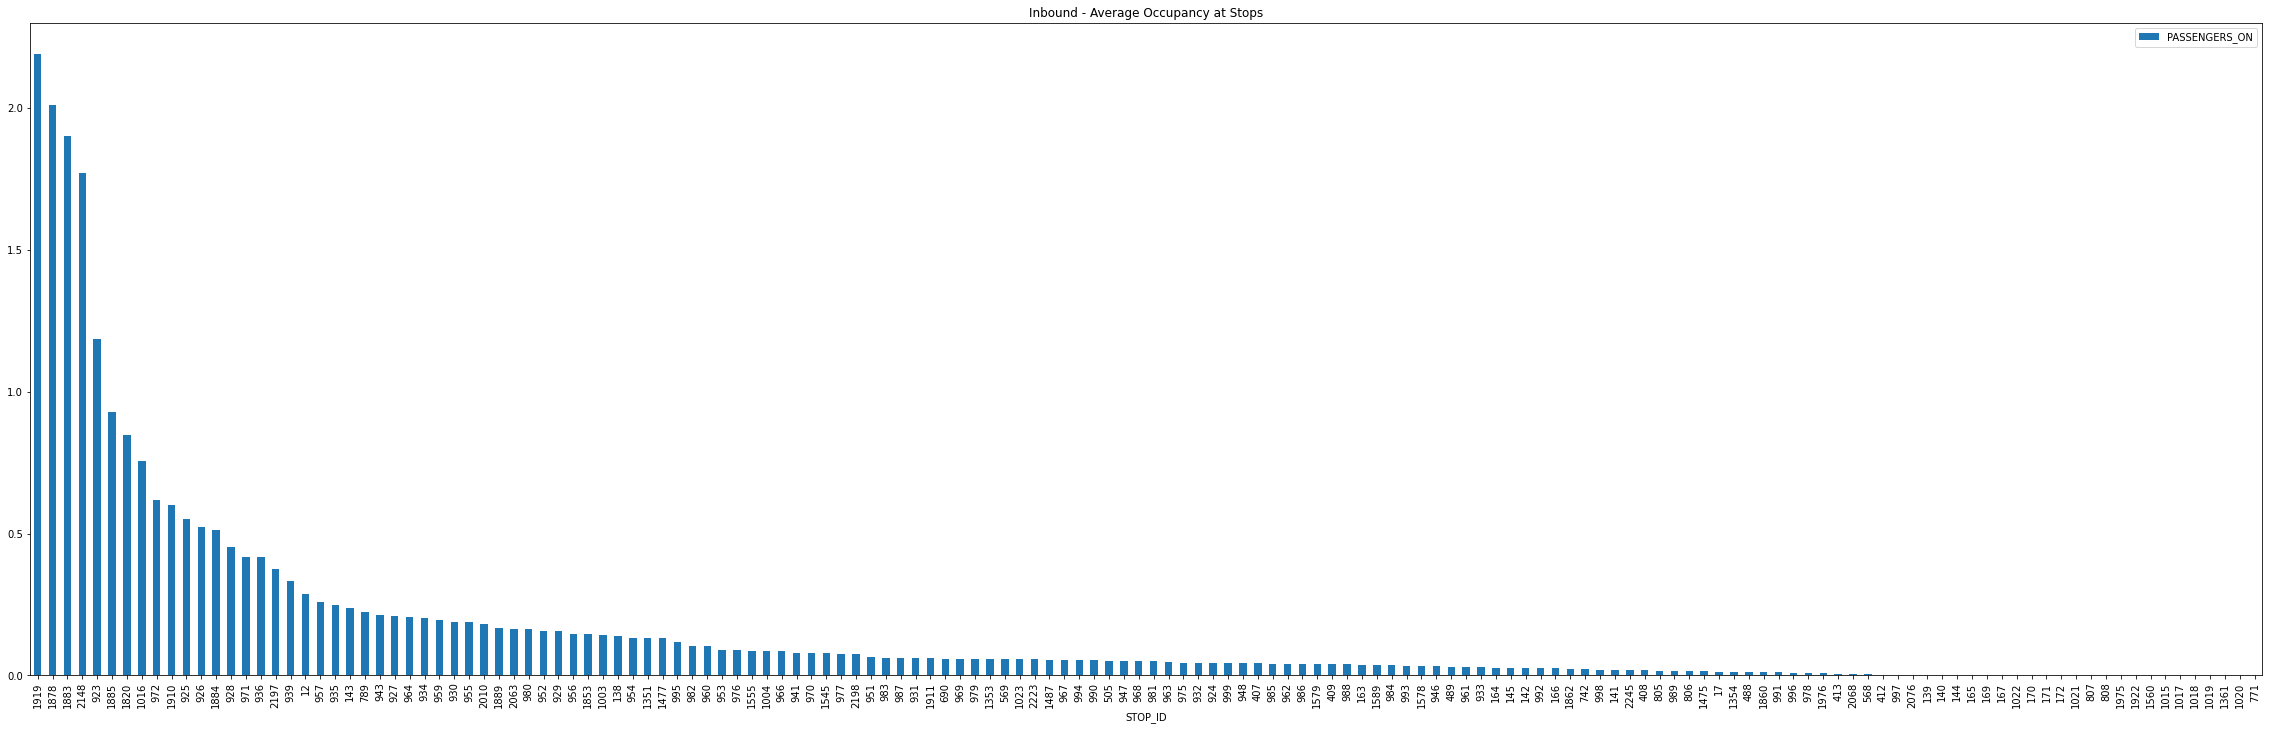

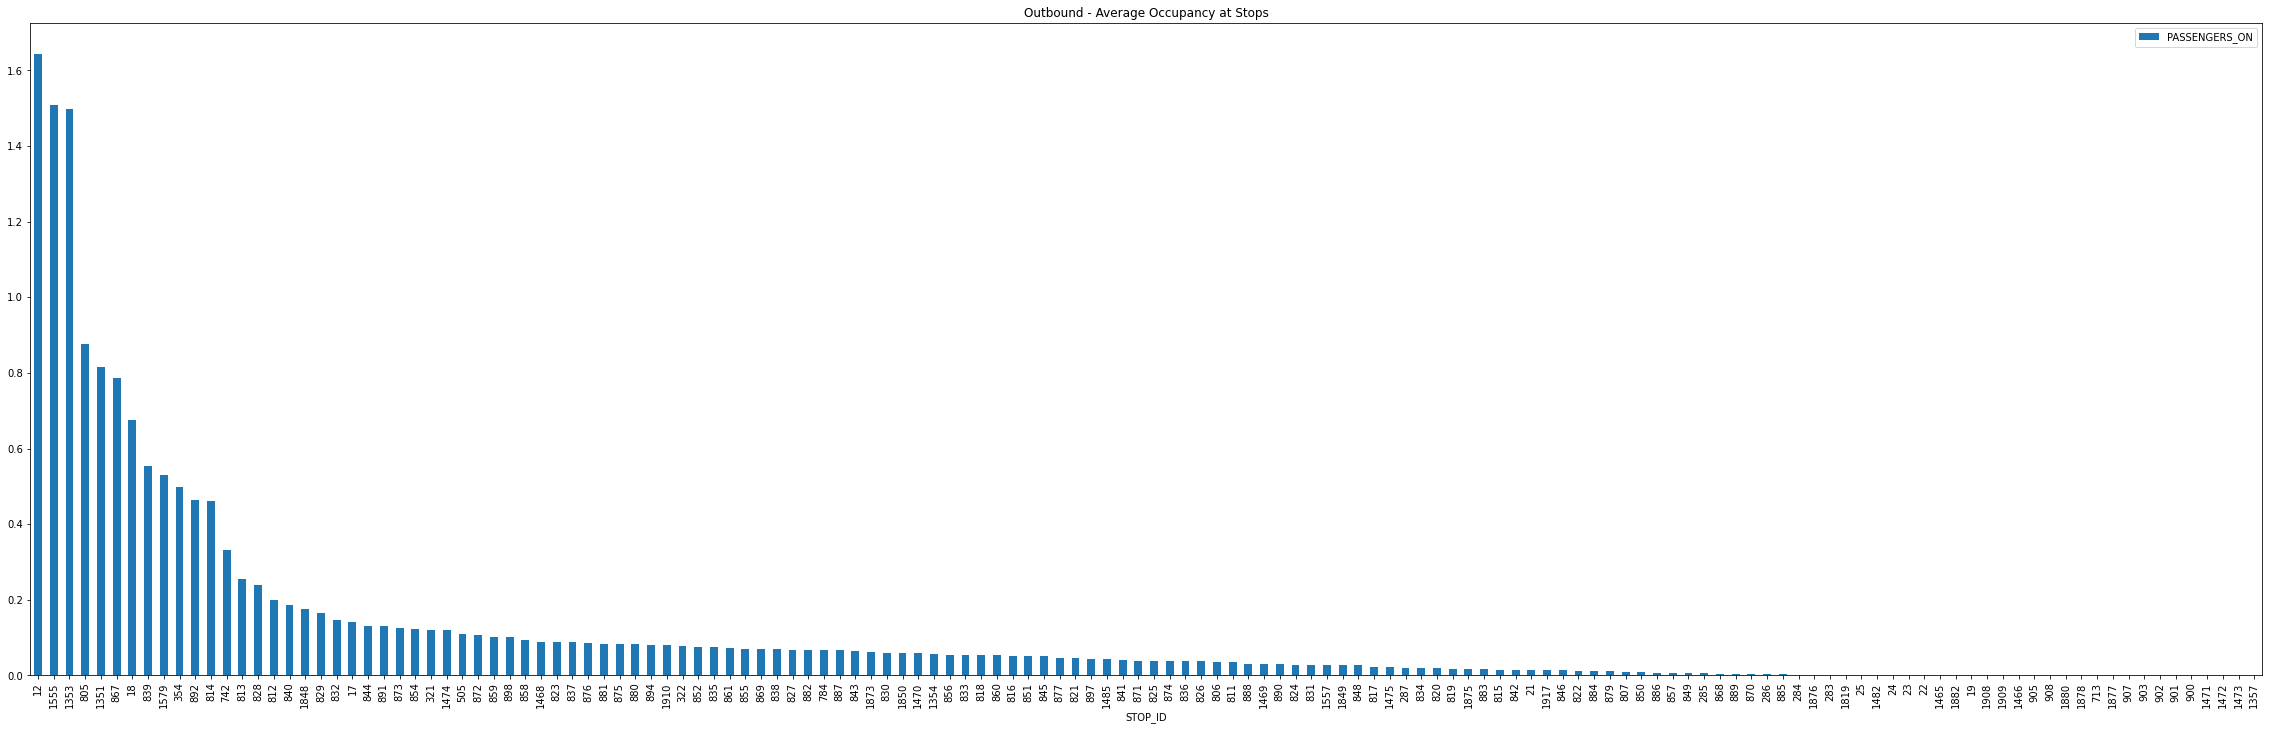

In [ ]:
Inbound_Stops = Inbound.groupby(['STOP_ID'])['PASSENGERS_ON'].mean().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})

Inbound_Stops.plot(x="STOP_ID", y=["PASSENGERS_ON"], kind="bar",title="Inbound - Average Occupancy at Stops")
fig = plt.gcf()
fig.set_size_inches(40, 12)
plt.show()

Outbound_Stops = Outbound.groupby(['STOP_ID'])['PASSENGERS_ON'].mean().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
Outbound_Stops.plot(x="STOP_ID", y=["PASSENGERS_ON"], kind="bar",title="Outbound - Average Occupancy at Stops")
fig = plt.gcf()
fig.set_size_inches(40, 12)
plt.show()

In [ ]:
def Plot_Board_Alight_Stop(tripID):
  Trip_Specific = Route_4_DF[Route_4_DF.trip_id == tripID]

  STOP_ID = list(set(list(Trip_Specific.STOP_ID)))
  Avg_Occupancy = []
  Avg_Boarding = []
  Avg_Alighting = []
  for stop in STOP_ID:
      Avg_Occupancy.append(Trip_Specific.loc[(Trip_Specific['STOP_ID'] == stop), 'PASSENGERS_IN'].mean())
      Avg_Boarding.append(Trip_Specific.loc[(Trip_Specific['STOP_ID'] == stop), 'PASSENGERS_ON'].mean())
      Avg_Alighting.append(Trip_Specific.loc[(Trip_Specific['STOP_ID'] == stop), 'PASSENGERS_OFF'].mean())

  print(f'Total Stops = {len(STOP_ID)}')
  
  X = np.arange(len(STOP_ID))
  width = 0.25
  fig, ax = plt.subplots()
  boarding = ax.bar(X - width / 2, Avg_Boarding, width, label='Average Boarding')
  alighting = ax.bar(X + width / 2, Avg_Alighting, width, label='Average Alighting')

  ax.set_ylabel('Average')
  ax.set_xlabel('Stop ID')
  ax.set_xticks(X)
  ax.set_xticklabels(STOP_ID, rotation=45, ha="right",size = 13)
  ax.set_title(f'Average Boarding/Alighting at each Stop for Trip {tripID}')
  ax.legend()
  ax.margins(x=0)
  fig = plt.gcf()
  fig.set_size_inches(40, 12)
  # fig.tight_layout()
  plt.show()


# For one particular trip, boarding & alighting count at each stop

152324020.0
Total Stops = 98


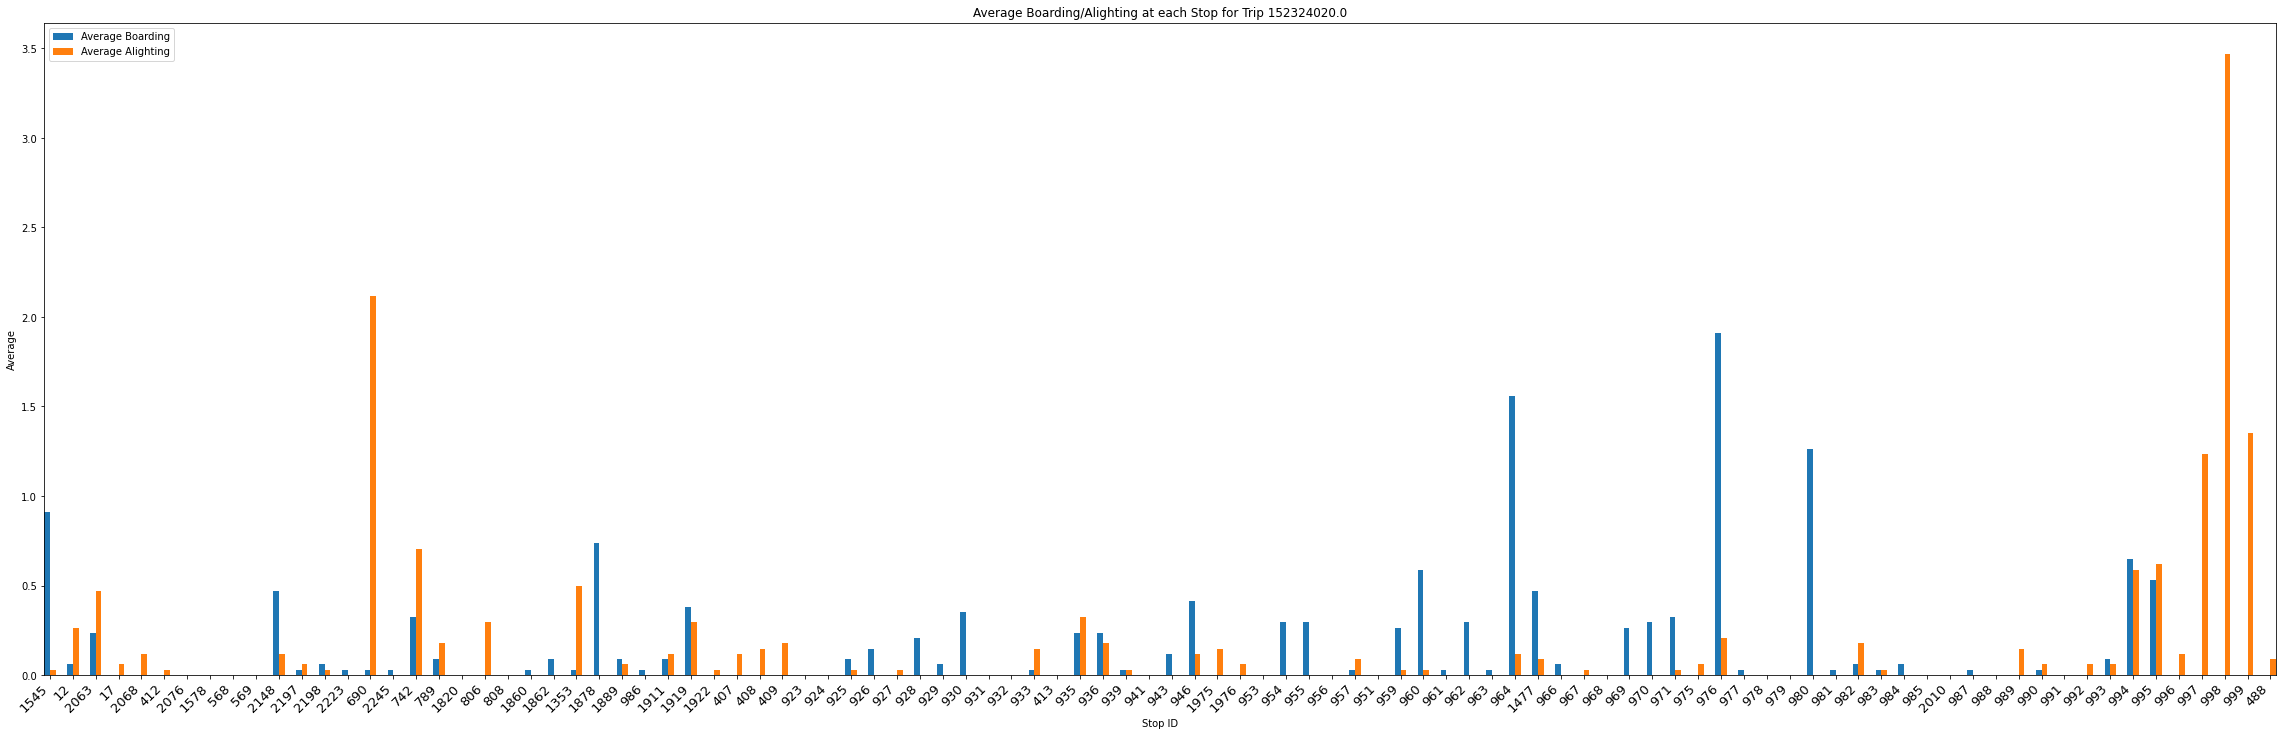

In [ ]:
Route_4_DF = (df[df.route_id == '4'])
Route_4_DF_Inbound = Route_4_DF[Route_4_DF.direction_id == 1]
Trips_route4 = Route_4_DF_Inbound.trip_id.unique()
print(Trips_route4[0])

c = 0
for i in Trips_route4:
  Trip_Specific = Route_4_DF_Inbound[Route_4_DF_Inbound.trip_id == i]
  NumberOfStops= len(Route_4_DF_Inbound.groupby(['STOP_ID']).size().reset_index().rename(columns={0: 'count'}))
  # print(f"Trip {i} has {len(Trip_Specific.groupby(['STOP_ID']).size().reset_index().rename(columns={0: 'count'}))} Stops")

Plot_Board_Alight_Stop(Trips_route4[0])

In [ ]:
Dates = Route_4_DF.SURVEY_DATE.unique()
print(len(Dates))
print(sorted(Dates))

168
['1/10/20 0:00', '1/11/20 0:00', '1/12/20 0:00', '1/13/20 0:00', '1/14/20 0:00', '1/15/20 0:00', '1/16/20 0:00', '1/17/20 0:00', '1/18/20 0:00', '1/19/20 0:00', '1/2/20 0:00', '1/21/20 0:00', '1/22/20 0:00', '1/23/20 0:00', '1/24/20 0:00', '1/25/20 0:00', '1/26/20 0:00', '1/27/20 0:00', '1/28/20 0:00', '1/29/20 0:00', '1/3/20 0:00', '1/30/20 0:00', '1/31/20 0:00', '1/4/20 0:00', '1/5/20 0:00', '1/6/20 0:00', '1/7/20 0:00', '1/8/20 0:00', '1/9/20 0:00', '2/1/20 0:00', '2/10/20 0:00', '2/11/20 0:00', '2/12/20 0:00', '2/13/20 0:00', '2/14/20 0:00', '2/15/20 0:00', '2/16/20 0:00', '2/17/20 0:00', '2/18/20 0:00', '2/19/20 0:00', '2/2/20 0:00', '2/20/20 0:00', '2/21/20 0:00', '2/22/20 0:00', '2/23/20 0:00', '2/24/20 0:00', '2/25/20 0:00', '2/26/20 0:00', '2/27/20 0:00', '2/28/20 0:00', '2/29/20 0:00', '2/3/20 0:00', '2/4/20 0:00', '2/5/20 0:00', '2/6/20 0:00', '2/7/20 0:00', '2/8/20 0:00', '2/9/20 0:00', '3/1/20 0:00', '3/10/20 0:00', '3/11/20 0:00', '3/12/20 0:00', '3/13/20 0:00', '3/14

In [ ]:
Date_Specific = Route_4_DF[Route_4_DF.SURVEY_DATE == '6/9/20']
Trip_Specific = Date_Specific[Route_4_DF.trip_id == Trips_route4[0]]
print(f'Trip ID {Trips_route4[0]}\t Date 6/9/20\n')
print(Trip_Specific[['Date_Time','STOP_ID','stop_sequence','FIRST_LAST_STOP','PASSENGERS_IN']].sort_values('stop_sequence'))
# print(Trip_Specific.groupby(['STOP_ID'])['stop_sequence'].size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'}))



Trip ID 152324020.0	 Date 6/9/20

              Date_Time  STOP_ID  stop_sequence  FIRST_LAST_STOP  PASSENGERS_IN
21  2020-06-09 04:50:00     1878            1.0                1              1
88  2020-06-09 04:53:23      923            2.0                2              1
10  2020-06-09 04:53:58     2148            3.0                2              2
87  2020-06-09 04:54:36      924            4.0                2              2
86  2020-06-09 04:55:10      925            5.0                2              2
..                  ...      ...            ...              ...            ...
90  2020-06-09 05:48:46      806           94.0                2              5
89  2020-06-09 05:49:47      808           95.0                2              5
17  2020-06-09 05:56:52     1922           96.0                2              5
14  2020-06-09 05:58:16     2010           97.0                2              5
93  2020-06-09 06:00:00      690           98.0                3              0

[98 r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
Sorted_by_Date = Route_4_DF.sort_values('Date_Time')
Sorted_by_Date.to_csv('drive/My Drive/Route4_chattanooga_bus_occupancy.csv',index=False)